In [22]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import math

In [23]:
cuda_availability = torch.cuda.is_available()

print('CUDA availability:', ('True' if cuda_availability else 'False'))
device = torch.device('cuda:0' if cuda_availability else 'cpu')

class_names = [str(x) for x in range(10)]+list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')+list('abcdefghijklmnopqrstuvwxyz')

CUDA availability: True


### Transforms

In [24]:
mean=[0.5] * 3
std=[0.5] * 3

def binarize(im):
    im = (im-im.min()) / (im.max()-im.min())
    im = im > 0.55
    im = im.float()
    return im

trans = transforms.Compose([
    transforms.Resize((80,64)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std
    ),
    transforms.Lambda(binarize)
])

### Dataloader

In [25]:
batch_size = 1

test_path = 'test'

test_dataset = datasets.ImageFolder(test_path, trans)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

### Sample batch

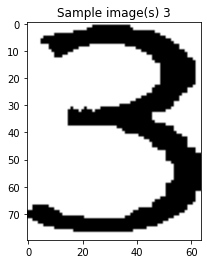

In [26]:
def imshow(im, title=None, save=None):
    im = im.numpy().transpose((1, 2, 0))
    plt.imshow(im)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

inputs, classes = next(iter(testloader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=f'Sample image(s) {"".join(class_names[x] for x in classes)}', save='Sample_test.png')

In [27]:
def visualize_model(model, dataloader, num_images=batch_size):
    was_training = model.training
    model.eval()
    images_so_far = 0
    img_total = 0
    fig = plt.figure(figsize=(8,6))
    
    correct = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels)
            img_total += len(preds)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(math.ceil(num_images/8), 8, images_so_far)
                ax.axis('off')
                ax.set_title(class_names[preds[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    acc = correct.double() / img_total
                    print('Accuracy:', acc.item())
                    return

        acc = correct.double() / img_total
        print('Accuracy:', acc.item())
        model.train(mode=was_training)

### Load and predict

Accuracy: 1.0


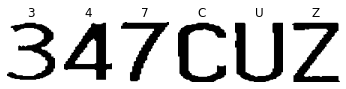

In [32]:
load_batch = 32
load_epochs = 16
model_load = torch.load(f'trained_{load_batch}_{load_epochs}.pth')

visualize_model(model_load, testloader, 6)

plt.savefig(f'Result_{trained_batch}_{trained_epochs}.png')
plt.show()